In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import copy
import random
import transformers
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import shap2
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline

# Create Data Set

In [2]:
columns = ['Text', 'Length', 'Clear', 'Label', 'Train'] #Label, negative=0, positive=1

data = [("One of the most funny movies I've ever watched.", 1, True, 1, True),
        ("I've never seen a film that is so patetic.", 1, True, 0, True),
        ("It was a good experience to watch this movie.", 1, True, 1, False),
        ("The best adaptation of a book into movies I've ever seen.", 1, True, 1, False),
        ("Watching this film was a complete waist of time.", 1, True, 0, False),
        ("I wasn't expecting such a bad film coming from this director.", 1, True, 0, False),
        ("The movie is too long, but the screenplay is good", 1, False, 1, True),
        ("If it wasn't for the actors I wouldn't make it till the end.", 1, False, 0, True),
        ("The actress in the leading role saved the movie.", 1, False, 1, False),
        ("Although the actors were not great the story caught me.", 1, False, 1, False),
        ("I'm happy that the film wasn't longer.", 1, False, 0, False),
        ("They managed to make a poor movie with a terrific casting.", 1, False, 0, False),
        ("A masterpiece of the cinema, I would say. The actors are extremely well chosen and the dialogues are amazing.", 2, True, 1, True),
        ("This is a well written film with lots of twists that kept me guessing up until the end. However, the violence scenes are discomforting", 2, False, 1, True),
        ("I laughed all the way through this rotten movie. It's so unbelievable that Hollywood has made such a horrible film.", 2, True, 0, False),
        ("So funny and embarrassing at the same time. If you're looking for a trash film to laugh at, this one is a good choice.", 2, False, 0, True),
        ("A masterful production about one of the great masters of comedy and his life. The sets are terribly well done.", 2, True, 1, False),
        ("It's a unique film. It gives us our only chance to see this young actor in all his glory playing the main role.", 2, True, 1, False),
        ("I do like the beautiful scenes of this movie. However, it cannot make me accept the idea that people should die for a tyrant.", 2, False, 1, False),
        ("I did have a little trouble with the main character having such an epiphany so quickly. However, within this world, it needed to happen.", 2, False, 1, False),
        ("Not only that the storyline and script was wretched. I don't know why this movie was made in the first place.", 2, True, 0, False),
        ("For a thriller you'd better deliver more than name actors and talk. The first third of this movie was nothing but talk, and more talk.", 2, True, 0, True),
        ("It's more like a home video shot with very minimal lighting. If I made a movie like this it would have been a short.", 2, False, 0, False),
        ("The film does a good job of sparking viewers' interest in the events. Still, many of the characters were only very briefly touched upon.", 2, False, 0, False),
        ("I like this movie because it is a fine work of cinema. I was made by people who care enough to make it art and not just home movies. I was mesmerized by the sound design and camera sequences.", 3, True, 1, True),
        ("The symbolic use of objects, form editing, the position of characters in the scene: we can see how they were intentionally chosen. The director was very smart. No wonder the film earned so many awards.", 3, False, 1, False),
        ("This is perhaps the most feel good movie I have ever seen. It was made with care and in very good taste. You cannot help but smile all through it, except when you're crying happy tears.", 3, True, 1, False),
        ("What can you say about this film: amazing, fantastic, disturbing, hilarious. These words are not big enough to describe it. From wobbly, garbled beginning to profound end, this movie will entertain throughout.", 3, True, 1, False),
        ("I enjoyed the twists and turns in the plot of the film. The costumes and attention to detail was remarkable for its time. However, I disagree in the way they characterize the inhabitants of the feudal village.", 3, False, 1, True),
        ("The plot of this film is a bit far-fetched. Nevertheless, it is worth seeing just for the performances of the two main actors. Entertaining and fun, this is a hour and a half of easy watching.", 3, False, 1, False),
        ("I am an avid watcher of bad cinema, but this movie is virtually unwatchable. I'm sorry, but I have to not recommend this waste of disk. If you come across this one in the rental store pass on by.", 3, True, 0, True),
        ("Oh, how I laughed during those first couple of scenes. I have to admit that it is a great comedy, but it wasn't intended to be a comedy, it was intended as a social drama. I'm still confused.", 3, False, 0, True),
        ("Endless violins, alternated by a tired piano. Tired voices, tired actors and bored characters and situations. Boring is the long death of the mind, and this movie is, from that point of view, a public enemy.", 3, True, 0, False),
        ("I watched this movie so that you don't have to. I have great respect for the director, but with this film I don't know what he had in mind. Too bad the money wasn't spent on a better project.", 3, True, 0, False),
        ("The events in this film are absurd and ridiculous. The first scenes are indeed very funny, for all the wrong reasons. The special effects on the cars looked like something my 4 year old cousin could have done.", 3, False, 0, False),
        ("The trailer intrigued me so much I actually went to see it on opening weekend, something I never do. Needless to say I was very disappointed. The story has so much potential and it's frustrating to see it get screwed up.", 3, False, 0, False)
]

reviews_data = pd.DataFrame(data, columns=columns)

# Train NLP Model
## Model: Distilbert-base-uncased-finetuned-sst-2-english
https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

## 1) Build Model

In [3]:
X_train = reviews_data[(reviews_data['Train']==True)]['Text']
X_test = reviews_data[(reviews_data['Train']==False)]['Text']
y_train = reviews_data[(reviews_data['Train']==True)]['Label']
y_test = reviews_data[(reviews_data['Train']==False)]['Label']

In [4]:
tokenizer_test = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
tokenizer_train = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

# Maximum length of encoded reviews in the data set is 51
max_len = 51

In [5]:
batch_test = tokenizer_test(
    list(X_test),
    pad_to_max_length=True,
    max_length=max_len,
    truncation=True,
    return_tensors="pt"
)

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


In [6]:
batch_train = tokenizer_train(
    list(X_train),
    pad_to_max_length=True,
    max_length=max_len,
    truncation=True,
    return_tensors="pt"
)

## 2) Predict

### Test Data

In [7]:
labels_test = list(y_test)

outputs_test = model(**batch_test, labels = torch.tensor(labels_test), return_dict=True)

predict_test = torch.argmax(outputs_test.logits, dim=1).flatten()

### Train Data

In [8]:
labels_train = list(y_train)

outputs_train = model(**batch_train, labels = torch.tensor(labels_train), return_dict=True)

predict_train = torch.argmax(outputs_train.logits, dim=1).flatten()

## 3) Evaluate

In [9]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predict_test, average='binary')
acc = accuracy_score(y_test, predict_test)

In [10]:
evaluate = pd.DataFrame([acc,f1,precision,recall], index=['Acc','F1','Precision','Recall'], columns=['DistilBERT']).transpose()
evaluate

Acc   F1  Precision    Recall
DistilBERT  0.791667  0.8   0.769231  0.833333

# Explain with SHAP

In [11]:
model_c = model.cuda()

In [12]:
reviews_test = list(X_test)
reviews_train = list(X_train)

## Test Data

In [13]:
def f_test(x):
    tv = torch.tensor([tokenizer_test.encode(v, pad_to_max_length=True, max_length=max_len, truncation=True) for v in x]).cuda()
    outputs = model_c(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [15]:
explainer_test = shap2.Explainer(f_test,tokenizer_test)
shap_values_test = explainer_test(reviews_test)

explainers.Partition is still in an alpha state, so use with caution...
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

## Train Data

In [16]:
def f_train(x):
    tv = torch.tensor([tokenizer_train.encode(v, pad_to_max_length=True, max_length=max_len, truncation=True) for v in x]).cuda()
    outputs = model_c(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [17]:
explainer_train = shap2.Explainer(f_train,tokenizer_train)
shap_values_train = explainer_train(reviews_train)

explainers.Partition is still in an alpha state, so use with caution...


# Perturbe the SHAP explanation

In [18]:
idx = 5

In [19]:
def swaptotherightshift(alist, a):
    slist = copy.deepcopy(alist)
    a = sorted(a)
    b = a + np.ones(len(a), dtype=int)

    for x,y in zip(a,b):
        if y >= len(slist):
            y = 0
        slist[x],slist[y] = -slist[y],-slist[x]

    return slist

In [20]:
def model_swap_shift(shap_obj, percentage):
    nshap_obj = copy.deepcopy(shap_obj)
    seed = 30
    new_values = []
    new_hvalues = []
    for i in nshap_obj:
        #First and last strings are always "", so we account for them
        qtt = int((len(i.values)-2)*percentage)
        random.seed(seed)
        #By not including the second last token (usually a '.'), we avoid swapping it with the empty token "".
        rnums = random.sample(range(1,len(i.values)-2),qtt)

        new_values.append(swaptotherightshift(i.values,rnums))
        new_hvalues.append(swaptotherightshift(i.hierarchical_values,rnums))

        seed += 1

    nshap_obj.values = new_values
    nshap_obj.hierarchical_values = new_hvalues

    return nshap_obj

## Create Model 2

### Model 2 = - (Model 1)

In [21]:
shap_values_test2 = copy.deepcopy(shap_values_test)
shap_values_train2 = copy.deepcopy(shap_values_train)

In [22]:
shap_values_test2.values = -shap_values_test2.values
shap_values_test2.base_values = -shap_values_test2.base_values
shap_values_test2.hierarchical_values = -shap_values_test2.hierarchical_values

shap_values_train2.values = -shap_values_train2.values
shap_values_train2.base_values = -shap_values_train2.base_values
shap_values_train2.hierarchical_values = -shap_values_train2.hierarchical_values

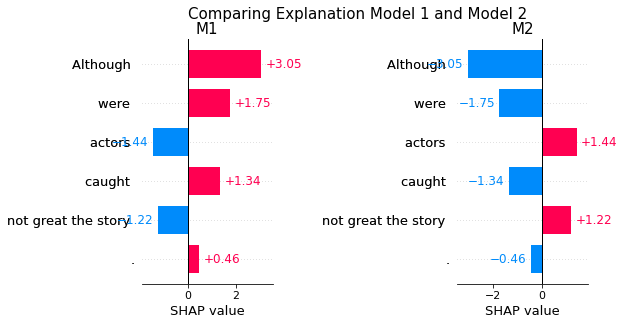

In [33]:
fig = plt.figure(figsize=(100,100))
fig.suptitle("Comparing Explanation Model 1 and Model 2",fontsize=15)
plt.subplot(131)
plt.title('M1',fontsize=15)
shap2.bar_plot(shap_values_test[idx], relevance=0.1, hierarchical=True, show=False)
plt.subplot(133)
plt.title('M2',fontsize=15)
shap2.bar_plot(shap_values_test2[idx], relevance=0.1, hierarchical=True, show=False)
plt.show()

In [58]:
shap2.plots.text(shap_values_test[idx], relevance=0.1)

In [59]:
shap2.plots.text(shap_values_test2[idx], relevance=0.1)

## Create Model 3

### Model3 shap values and hierarchical values are Model1 50% randomly swapped to the right and signs inverted.

In [34]:
shap_values_test3 = copy.deepcopy(shap_values_test)
shap_values_train3 = copy.deepcopy(shap_values_train)

In [35]:
shap_values_test3 = model_swap_shift(shap_values_test3,0.5)
shap_values_train3 = model_swap_shift(shap_values_train3,0.5)

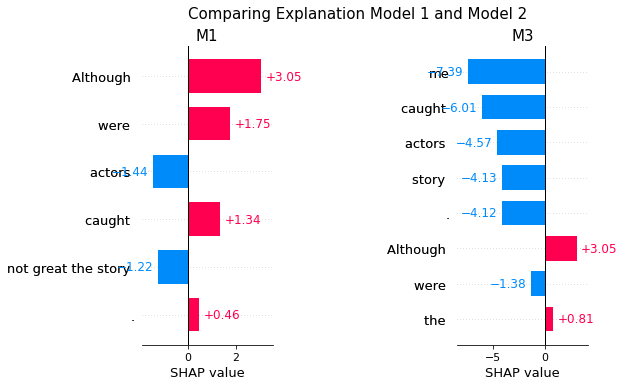

In [37]:
fig = plt.figure(figsize=(100,100))
fig.suptitle("Comparing Explanation Model 1 and Model 2",fontsize=15)
plt.subplot(131)
plt.title('M1',fontsize=15)
shap2.bar_plot(shap_values_test[idx], relevance=0.1, hierarchical=True, show=False)
plt.subplot(133)
plt.title('M3',fontsize=15)
shap2.bar_plot(shap_values_test3[idx], relevance=0.1, hierarchical=True, show=False)
plt.show()

In [60]:
shap2.plots.text(shap_values_test[idx], relevance=0.1)

In [61]:
shap2.plots.text(shap_values_test3[idx], relevance=0.1)

# Extend Data Set and Create AMT Experiment File

### Remark: SHAP Text and Box Plot methods were modified to display the same number of features and combination of tokens. It is important to extend the data set with explanation metadata to keep control of what was displayed during the experiment.


In [38]:
Train = reviews_data[(reviews_data['Train']==True)]
Test = reviews_data[(reviews_data['Train']==False)]

In [39]:
# From text_plot.py

def process_shap_values(shap_values, group_threshold, separator):

    # unpack the Explanation object
    tokens = shap_values.data
    clustering = getattr(shap_values, "clustering", None)
    if getattr(shap_values, "hierarchical_values", None) is not None:
        values = shap_values.hierarchical_values
    else:
        values = shap_values.values

    # See if we got hierarchical input data. If we did then we need to reprocess the 
    # shap_values and tokens to get the groups we want to display
    M = len(tokens)
    if len(values) != M:
        
        # make sure we were given a partition tree
        if clustering is None:
            raise ValueError("The length of the attribution values must match the number of " + \
                             "tokens if shap_values.clustering is None! When passing hierarchical " + \
                             "attributions the clustering is also required.")
        
        # compute the groups, lower_values, and max_values
        groups = [[i] for i in range(M)]
        lower_values = np.zeros(len(values))
        lower_values[:M] = values[:M]
        max_values = np.zeros(len(values))
        max_values[:M] = np.abs(values[:M])
        for i in range(clustering.shape[0]):
            li = int(clustering[i,0])
            ri = int(clustering[i,1])
            groups.append(groups[li] + groups[ri])
            lower_values[M+i] = lower_values[li] + lower_values[ri] + values[M+i]
            max_values[i+M] = max(abs(values[M+i]) / len(groups[M+i]), max_values[li], max_values[ri])
    
        # compute the upper_values
        upper_values = np.zeros(len(values))
        def lower_credit(upper_values, clustering, i, value=0):
            if i < M:
                upper_values[i] = value
                return
            li = int(clustering[i-M,0])
            ri = int(clustering[i-M,1])
            upper_values[i] = value
            value += values[i]
            lower_credit(upper_values, clustering, li, value * 0.5)
            lower_credit(upper_values, clustering, ri, value * 0.5)

        lower_credit(upper_values, clustering, len(values) - 1)
        
        # the group_values comes from the dividends above them and below them
        group_values = lower_values + upper_values

        # merge all the tokens in groups dominated by interaction effects (since we don't want to hide those)
        new_tokens = []
        new_values = []
        group_sizes = []
        def merge_tokens(new_tokens, new_values, group_sizes, i):
            
            # return at the leaves
            if i < M and i >= 0:
                new_tokens.append(tokens[i])
                new_values.append(group_values[i])
                group_sizes.append(1)
            else:

                # compute the dividend at internal nodes
                li = int(clustering[i-M,0])
                ri = int(clustering[i-M,1])
                dv = abs(values[i]) / len(groups[i])
                
                # if the interaction level is too high then just treat this whole group as one token
                if dv > group_threshold * max(max_values[li], max_values[ri]):
                    new_tokens.append(separator.join([tokens[g] for g in groups[li]]) + separator + separator.join([tokens[g] for g in groups[ri]]))
                    new_values.append(group_values[i])
                    group_sizes.append(len(groups[i]))
                # if interaction level is not too high we recurse
                else:
                    merge_tokens(new_tokens, new_values, group_sizes, li)
                    merge_tokens(new_tokens, new_values, group_sizes, ri)
        merge_tokens(new_tokens, new_values, group_sizes, len(group_values) - 1)
        
        # replance the incoming parameters with the grouped versions
        tokens = np.array(new_tokens)
        values = np.array(new_values)
        group_sizes = np.array(group_sizes)
        M = len(tokens) 
    else:
        group_sizes = np.ones(M)

    return tokens, values, group_sizes

In [40]:
# Determine feature length and explanation prediction

def get_prediction(shap_values, relevance):
    sum_shap = 0
    
    tokens, values, group_sizes = process_shap_values(shap_values, 1, '')
    
    if relevance != None:
        most_rel = len((np.where(abs(values) > (max(abs(values))*relevance)))[0])
        if most_rel > 15:
            most_rel = 15
        max_display = most_rel
    else:
        max_display = len(shap_values)
    
    # display only choosen indices
    top_inds = np.argsort(-np.abs(values))[:max_display]
    
    for i in range(len(tokens)):
        if i in top_inds:

            sum_shap += values[i]
    fx = sum_shap + shap_values.base_values
    if fx < shap_values.base_values:
        return 0
    else:
        return 1

In [41]:
# Check if reducing feature length yields different explanation prediction

def both_same_prediction(shap_values):
    pred_after = []
    pred_before = []
    for s in shap_values:
        pred_after.append(get_prediction(s,0.1))
        
        fx = sum(s.values) + s.base_values
        if fx < s.base_values:
            pred_before.append(0)
        else:
            pred_before.append(1)
        
    return {'same_preds':pred_after == pred_before,'pred_after':pred_after, 'pred_before':pred_before}

In [42]:
# Determine maximum feature length

def determine_maxlength(shap_values, relevance):

    tokens, values, group_sizes = process_shap_values(shap_values, 1, '')
    
    if relevance != None:
        most_rel = len((np.where(abs(values) > (max(abs(values))*relevance)))[0])
        if most_rel > 15:
            most_rel = 15
        max_display = most_rel
    else:
        max_display = len(shap_values)
        
    return max_display

In [43]:
def feature_length(shap_values):
    f_length = []
    for s in shap_values:
        f_length.append(determine_maxlength(s, 0.1))
    return f_length

## 1) Generate Explanation Metadata

### Check whether by changing number of displayed features the explanation prediction changes

In [44]:
pred1 = both_same_prediction(shap_values_test)
pred2 = both_same_prediction(shap_values_test2)
pred3 = both_same_prediction(shap_values_test3)

In [51]:
pred3['same_preds']

False

In [46]:
pred_train1 = both_same_prediction(shap_values_train)
pred_train2 = both_same_prediction(shap_values_train2)
pred_train3 = both_same_prediction(shap_values_train3)

In [54]:
pred_train3['same_preds']

False

#### Prediction changes only for model 3.

### Compute the length of the features displayed

In [55]:
f_length1 = feature_length(shap_values_test)
f_length2 = feature_length(shap_values_test2)
f_length3 = feature_length(shap_values_test3)

In [56]:
f_length_train1 = feature_length(shap_values_train)
f_length_train2 = feature_length(shap_values_train2)
f_length_train3 = feature_length(shap_values_train3)

### Append explanation prediction and feature length to data set

#### Because prediction changes when limiting the feature length, the data set truth prediction is the one corresponding to the displayed number of features.

In [57]:
pred1 = pd.Series(pred1['pred_after'], name='Prediction_M1')
pred2 = pd.Series(pred2['pred_after'], name='Prediction_M2')
pred3 = pd.Series(pred3['pred_after'], name='Prediction_M3')
pred_test = pd.concat([pred1,pred2,pred3], axis=1)

In [67]:
pred_train1 = pd.Series(pred_train1['pred_after'], name='Prediction_train_M1')
pred_train2 = pd.Series(pred_train2['pred_after'], name='Prediction_train_M2')
pred_train3 = pd.Series(pred_train3['pred_after'], name='Prediction_train_M3')
pred_train = pd.concat([pred_train1,pred_train2,pred_train3], axis=1)

In [68]:
f_length1 = pd.Series(f_length1, name='Feature_number_M1')
f_length2 = pd.Series(f_length2, name='Feature_number_M2')
f_length3 = pd.Series(f_length3, name='Feature_number_M3')
f_length_test = pd.concat([f_length1,f_length2,f_length3], axis=1)

In [69]:
f_length_train1 = pd.Series(f_length_train1, name='Feature_number_train_M1')
f_length_train2 = pd.Series(f_length_train2, name='Feature_number_train_M2')
f_length_train3 = pd.Series(f_length_train3, name='Feature_number_train_M3')
f_length_train = pd.concat([f_length_train1,f_length_train2,f_length_train3], axis=1)

In [70]:
Test_new = pd.concat([Test.reset_index(drop=True),pred_test,f_length_test], axis=1)
Train_new = pd.concat([Train.reset_index(drop=True),pred_train,f_length_train], axis=1)

## 2) Create File Names

In [71]:
def exp_filenames(data):
    file_name = []
    for i,r in data.iterrows():
        name = ''
        if r['Clear'] == True:
            name += 'C'
        else:
            name += 'U'

        if r['Length'] == 1:
            name += 'l1'
        elif r['Length'] == 2:
            name += 'l2'
        else:
            name += 'l3'

        if r['Train'] == True:
            name += 'Tr'
        else:
            name += 'Ts'

        name += str(i)+'.png'
        file_name.append(name)
        
    return file_name

In [72]:
file_test = pd.Series(exp_filenames(Test_new), name='File_name')
file_train = pd.Series(exp_filenames(Train_new), name='File_name')

In [73]:
Test_new = pd.concat([Test_new,file_test], axis=1)
Train_new = pd.concat([Train_new,file_train], axis=1)

## 3) Create Trap and Gold Questions

In [74]:
trap_url_t = ['/text-plot-train/T_M1_Ul2Tr6.png',
            '/text-plot-train/T_M1_Cl2Tr7.png',
            '/text-plot-train/T_M2_Ul1Tr2.png',
            '/text-plot-train/T_M1_Ul1Tr3.png',
            '/text-plot-train/T_M2_Ul2Tr5.png'
            ]

trap_url_b = ['/bar-plot-train/B_M1_Ul2Tr6.png',
             '/bar-plot-train/B_M1_Cl2Tr7.png',
             '/bar-plot-train/B_M2_Ul1Tr2.png',
             '/bar-plot-train/B_M1_Ul1Tr3.png',
             '/bar-plot-train/B_M2_Ul2Tr5.png']

# Adapted from Train set indexes 6, 7, 2, 3, 5
trap_sentence = ['So funny and embarrassing... Attention, choose the answers as follows to show you are concentrated: for the first question select Negative, for the second, Confident, for the third, Agree, and for the last, Fair.',
                'For a thriller you\'d better deliver... Attention, choose the answers as follows to show you are concentrated: for the first question select Positive, for the second, Unconfident, for the third, Disagree, and for the last, Good.',
                'The movie is too long, but the... Attention, choose the answers as follows to show you are concentrated: for the first question select Positive, for the second, I don\'t know, for the third, Agree, and for the last, Excellent.',
                'If it wasn\'t for the actors... Attention, choose the answers as follows to show you are concentrated: for the first question select Negative, for the second, Very Confident, for the third, Disagree, and for the last, Poor.',
                'This is a well written film with... Attention, choose the answers as follows to show you are concentrated: for the first question select Positive, for the second, Very Unconfident, for the third, Agree, and for the last, Bad.'
                ]

trap_output = [1,0,0,0,0]

trap_answer = [{'prediction_t': 0, 'confidence_t': 4, 'understand_t': 4, 'quality_t': 3},
                  {'prediction_t': 1, 'confidence_t': 2, 'understand_t': 2, 'quality_t': 4},
                  {'prediction_t': 1, 'confidence_t': 3, 'understand_t': 4, 'quality_t': 5},
                  {'prediction_t': 0, 'confidence_t': 5, 'understand_t': 2, 'quality_t': 2},
                  {'prediction_t': 1, 'confidence_t': 1, 'understand_t': 4, 'quality_t': 1},
                 ]

In [75]:
gold_url = ['/bar-plot-train/B_M2_Ul3Tr11.png',
           '/bar-plot-train/B_M2_Cl1Tr0.png',
           '/bar-plot-train/B_M2_Cl2Tr4.png',
           '/bar-plot-train/B_M2_Cl3Tr10.png',
            '/text-plot-train/T_M2_Ul1Tr3.png',
            '/text-plot-train/T_M2_Cl3Tr8.png',
            '/text-plot-train/T_M1_Ul3Tr9.png'
           ]

# Train indexes 11, 0, 4, 10, 3, 8, 9
gold_sentence = ['Oh, how I laughed during those first couple of scenes. I have to admit that it is a great comedy, but it wasn\'t intended to be a comedy, it was intended as a social drama. I\'m still confused.',
                'One of the most funny movies I\'ve ever watched.',
                'A masterpiece of the cinema, I would say. The actors are extremely well chosen and the dialogues are amazing.',
                'I am an avid watcher of bad cinema, but this movie is virtually unwatchable. I\'m sorry, but I have to not recommend this waste of disk. If you come across this one in the rental store pass on by.',
                'If it wasn\'t for the actors I wouldn\'t make it till the end.',
                 'I like this movie because it is a fine work of cinema. I was made by people who care enough to make it art and not just home movies. I was mesmerized by the sound design and camera sequences.',
                 'I enjoyed the twists and turns in the plot of the film. The costumes and attention to detail was remarkable for its time. However, I disagree in the way they characterize the inhabitants of the feudal village.'
                ]

gold_output = [1,0,0,1,1,0,1]

gold_ans = [1,0,0,1,1,0,1]

In [76]:
M1 = 'M1_' + Test_new['File_name']
M2 = 'M2_' + Test_new['File_name']
M3 = 'M3_' + Test_new['File_name']

In [77]:
fnames = pd.concat([M1,M2,M3], ignore_index=True)

In [78]:
outputs = pd.concat([Test_new['Prediction_M1'],Test_new['Prediction_M2'],Test_new['Prediction_M3']], ignore_index=True).rename('Output')

In [79]:
sentences = pd.concat([Test_new['Text']]*3, ignore_index=True)

In [80]:
reviews_rows = pd.concat([sentences,fnames,outputs], axis=1)

In [81]:
tp_ans = pd.DataFrame(trap_answer)
tp_ans.columns = ['TP_ANS1','TP_ANS2','TP_ANS3','TP_ANS4']

In [82]:
trap_rows_t = pd.concat([pd.Series(trap_url_t, name='TP'),pd.Series(trap_sentence, name='STP'), pd.Series(trap_output, name='OTP'), tp_ans], axis=1)

In [83]:
trap_rows_b = pd.concat([pd.Series(trap_url_b, name='TP'),pd.Series(trap_sentence, name='STP'), pd.Series(trap_output, name='OTP'), tp_ans], axis=1)

In [84]:
trap_rows = pd.concat([trap_rows_t,trap_rows_b]*2, ignore_index=True)

In [85]:
gold_rows = pd.concat([pd.Series(gold_url, name='gold_clips'),pd.Series(gold_sentence, name='Sgold_clips'), pd.Series(gold_output, name='Ogold_clips'), pd.Series(gold_ans, name='gold_clips_ans')], axis=1)

In [86]:
gold_rows = pd.concat([gold_rows]*3, ignore_index=True)

## 4) Create AMT Data File

In [87]:
def createAmtDS(reviews,tp,gold,nplots=8,nrows=18):
    random.seed(32)
    buckets = ['/bar-plot-test/B_','/text-plot-test/T_']
    columns = []
    amtDS = []
    
    # Ensure that nplots and nrows are compatible with the number of reviews provided
    try: 
        if nplots*nrows!=len(reviews)*2:
            raise ValueError
    except ValueError:
        print('Number of stimuli per row is incompatible with number of rows.')
        
    # Ensure that there are enough trap and gold questions for the number of rows
    try:
        if (len(tp) < nrows) or (len(gold) < nrows):
            raise ValueError
    except ValueError:
        print('Length of Dataframes must be bigger than expected number of rows.')
    
    # Create column names for plots:
    for p in range(nplots):
        columns.append('Q'+str(p))
        columns.append('S'+str(p))
        columns.append('O'+str(p)) #for outputs
    
    # Sample reviews and reshape:
    samp_review = copy.deepcopy(reviews)
    samp_review = samp_review.sample(frac=1, random_state=1).reset_index(drop=True)
    
    url_b = buckets[0]+samp_review.iloc[:,1]
    url_t = buckets[1]+samp_review.iloc[:,1]
    sentences = samp_review['Text']
    outputs = samp_review['Output']
    
    # Create Dictionary
    amt_dict = {}
    for c in columns:
        amt_dict.update({c:None})

    # Add Columns to dictionary
    for i in range(int(nplots/2)):
        idx1 = i*nrows
        idx2 = (i+1)*nrows
        
        cnum1 = i
        cnum2 = i + int(nplots/2)
        
        text_plots = url_t.iloc[idx1:idx2].reset_index(drop=True)
        box_plots = url_b.iloc[idx1:idx2].reset_index(drop=True)
        rev_sent = sentences[idx1:idx2].reset_index(drop=True)
        rev_output = outputs[idx1:idx2].reset_index(drop=True)
        
        amt_dict['Q'+str(cnum1)] = text_plots
        amt_dict['Q'+str(cnum2)] = box_plots
        amt_dict['S'+str(cnum1)] = rev_sent
        amt_dict['S'+str(cnum2)] = rev_sent
        amt_dict['O'+str(cnum1)] = rev_output
        amt_dict['O'+str(cnum2)] = rev_output

    amt_dict['TP'] = tp['TP'][:nrows]
    amt_dict['STP'] = tp['STP'][:nrows]
    amt_dict['OTP'] = tp['OTP'][:nrows]
    amt_dict['TP_ANS1'] = tp['TP_ANS1'][:nrows]
    amt_dict['TP_ANS2'] = tp['TP_ANS2'][:nrows]
    amt_dict['TP_ANS3'] = tp['TP_ANS3'][:nrows]
    amt_dict['TP_ANS4'] = tp['TP_ANS4'][:nrows]
    amt_dict['gold_clips'] = gold['gold_clips'][:nrows]
    amt_dict['Sgold_clips'] = gold['Sgold_clips'][:nrows]
    amt_dict['Ogold_clips'] = gold['Ogold_clips'][:nrows]
    amt_dict['gold_clips_ans'] = gold['gold_clips_ans'][:nrows]
    
    amtDS = pd.DataFrame.from_dict(amt_dict)


    return amtDS

### Replace Integer with String in Output fields

In [60]:
class_dic = {0:'Negative',1:'Positive'}

In [61]:
reviews_rows['Output'] = reviews_rows['Output'].replace(class_dic)

In [62]:
gold_rows['Ogold_clips'] = gold_rows['Ogold_clips'].replace(class_dic)

In [63]:
trap_rows['OTP'] = trap_rows['OTP'].replace(class_dic)

### Create AMT Dataset

In [64]:
amt_ds = createAmtDS(reviews_rows,trap_rows,gold_rows)

# Prepare AMT Experiment Result File for Analysis

In [62]:
amt_data = pd.read_csv('Results/21-04-28_Batch_AMT.csv')

## 1) Create Dataset with one Quality Judgement per Row

In [63]:
def AMTWorkerStimuli(amt_ds):
    
    w_stimuli = {}
    
    urls = ['Answer.Q1_URL','Answer.Q2_URL','Answer.Q3_URL','Answer.Q4_URL','Answer.Q5_URL',
             'Answer.Q6_URL','Answer.Q7_URL','Answer.Q8_URL','Answer.Q9_URL', 'Answer.Q10_URL']
    ans_1 = ['Answer.prediction_q1', 'Answer.prediction_q2', 'Answer.prediction_q3', 'Answer.prediction_q4', 'Answer.prediction_q5',
             'Answer.prediction_q6', 'Answer.prediction_q7', 'Answer.prediction_q8', 'Answer.prediction_q9', 'Answer.prediction_q10']
    ans_2 = ['Answer.confidence_q1', 'Answer.confidence_q2', 'Answer.confidence_q3', 'Answer.confidence_q4', 'Answer.confidence_q5',
             'Answer.confidence_q6', 'Answer.confidence_q7', 'Answer.confidence_q8', 'Answer.confidence_q9', 'Answer.confidence_q10']
    ans_3 = ['Answer.understand_q1', 'Answer.understand_q2', 'Answer.understand_q3', 'Answer.understand_q4', 'Answer.understand_q5',
             'Answer.understand_q6', 'Answer.understand_q7', 'Answer.understand_q8', 'Answer.understand_q9','Answer.understand_q10']
    ans_4 = ['Answer.quality_q1', 'Answer.quality_q2', 'Answer.quality_q3', 'Answer.quality_q4', 'Answer.quality_q5',
             'Answer.quality_q6', 'Answer.quality_q7', 'Answer.quality_q8', 'Answer.quality_q9','Answer.quality_q10']
    
    workers = []
    url = []
    stimuli = []
    prediction = []
    confidence = []
    understand = []
    quality = []
    tp_check = []
    gq_check = []
    valid = []
    
    for index,row in amt_ds.iterrows():
        worker = row['WorkerId']
        tp_ch = row['Answer.tp_check']
        gq_ch = row['Answer.gq_check']
        if (tp_ch == -1) or (gq_ch == -1):
            check = -1
        else:
            check = 0
        
        for u,a1,a2,a3,a4 in zip(urls,ans_1,ans_2,ans_3,ans_4):

            if (row[u] != row['Input.TP']) and (row[u] != row['Input.gold_clips']):
                
                workers.append(worker)
                url.append(row[u])
                stimuli.append(row[u].rsplit('/', 1)[1].split('.',1)[0])
                prediction.append(row[a1])
                confidence.append(row[a2])
                understand.append(row[a3])
                quality.append(row[a4])
                tp_check.append(tp_ch)
                gq_check.append(gq_ch)
                valid.append(check)
                
                
    df = pd.concat([pd.Series(workers,name='WorkerId'),pd.Series(url,name='URL'),pd.Series(stimuli,name='F_name'),
                    pd.Series(prediction, name='prediction'),pd.Series(confidence, name='confidence'),pd.Series(understand, name='understand'),
                    pd.Series(quality, name='quality'), pd.Series(tp_check, name='tp_check'), pd.Series(gq_check, name='gq_check'), pd.Series(valid, name='valid')], axis=1)
    
    return df   

In [64]:
amt_df = AMTWorkerStimuli(amt_data)

In [65]:
amt_df

WorkerId                                                URL  \
0            1  https://bar-plot-test.s3.us-east-2.amazonaws.c...   
1            1  https://bar-plot-test.s3.us-east-2.amazonaws.c...   
2            1  https://bar-plot-test.s3.us-east-2.amazonaws.c...   
3            1  https://bar-plot-test.s3.us-east-2.amazonaws.c...   
4            1  https://text-plot-test.s3.us-east-2.amazonaws....   
...        ...                                                ...   
4155        89  https://bar-plot-test.s3.us-east-2.amazonaws.c...   
4156        89  https://text-plot-test.s3.us-east-2.amazonaws....   
4157        89  https://text-plot-test.s3.us-east-2.amazonaws....   
4158        89  https://text-plot-test.s3.us-east-2.amazonaws....   
4159        89  https://text-plot-test.s3.us-east-2.amazonaws....   

            F_name  prediction  confidence  understand  quality  tp_check  \
0      B_M1_Cl2Ts8           0           5           4        5         0   
1     B_M1_Ul3Ts19           1           5           4        4         0   
2      B_M2_Ul1Ts5           0           4           3        3         0   
3     B_M2_Cl2Ts10           0           4           2        2         0   
4     T_M1_Ul3Ts19           1           5           4        4         0   
...            ...         ...         ...         ...      ...       ...   
4155  B_M2_Ul2Ts14           1           5           4        3         0   
4156   T_M1_Cl2Ts9           1           4           4        3         0   
4157  T_M2_Ul2Ts12           1           3           3        2         0   
4158  T_M2_Ul2Ts14           1           4           3        3         0   
4159   T_M1_Ul1Ts4           0           3           3        3         0   

      gq_check  valid  
0            0      0  
1            0      0  
2            0      0  
3            0      0  
4            0      0  
...        ...    ...  
4155         0      0  
4156         0      0  
4157         0      0  
4158         0      0  
4159         0      0  

[4160 rows x 10 columns]

## 2) Expand Dataset with Metadata

### Extract Metadata from Previous Test Dataset

In [88]:
stimuli_metadata = copy.deepcopy(Test_new)

In [89]:
stimuli = stimuli_metadata['File_name'].str.rsplit('.',n=1,expand=True)[0]
stimuli_meta_new = pd.concat([stimuli_metadata, pd.Series(stimuli,name='Stimuli')],axis=1)

In [90]:
classification = pd.concat([stimuli_metadata['Prediction_M1'],stimuli_metadata['Prediction_M2'],stimuli_metadata['Prediction_M3']], ignore_index=True).rename('Classification')
f_number = pd.concat([stimuli_metadata['Feature_number_M1'],stimuli_metadata['Feature_number_M2'],stimuli_metadata['Feature_number_M3']], ignore_index=True).rename('Feature_number')
model = pd.Series(24*['M1']+24*['M2']+24*['M3'], name='Model')

In [91]:
stimuli_meta_three = pd.concat([stimuli_meta_new]*3, ignore_index=True)
stimuli_meta_all = pd.concat([stimuli_meta_three,classification,f_number,model], axis=1)

In [92]:
stimuli_meta_all['Model_Stimuli'] = stimuli_meta_all['Model']+'_'+stimuli_meta_all['Stimuli']

### Select only important columns

In [93]:
stimuli_meta_split = pd.concat([stimuli_meta_all[['Text', 'Length', 'Clear', 'Label']], stimuli_meta_all[['Stimuli',
       'Classification', 'Feature_number','Model','Model_Stimuli']]], axis=1)

### Create New Columns in AMT_DF to Map Metadata

In [94]:
st_name_b = amt_df['F_name'].str.rsplit('_',n=2,expand=True)
new_cols = pd.concat([pd.Series(st_name_b[0],name='Plot_type'), pd.Series(st_name_b[1],name='Model'),pd.Series(st_name_b[2],name='Stimuli')],axis=1)
new_cols['Model_Stimuli'] = new_cols['Model']+'_'+new_cols['Stimuli']
amt_df_new = pd.concat([amt_df,new_cols], axis=1)

### Merge AMT_DF and Metadata

In [95]:
amt_df_join = pd.merge(amt_df_new,stimuli_meta_split,on='Model_Stimuli', how='inner')

In [96]:
data_ds = pd.concat([amt_df_join[['WorkerId', 'URL', 'F_name', 'prediction', 'confidence',
       'understand', 'quality', 'tp_check', 'gq_check', 'valid','Plot_type', 'Model_x', 'Stimuli_x', 'Model_Stimuli', 'Text',
       'Length', 'Clear', 'Label']], amt_df_join[['Classification',
       'Feature_number']]], axis=1)
data_ds.rename(columns = {'Model_x':'Model','Stimuli_x':'Stimuli'}, inplace=True)

## 3) Exclude Quality Outliers

In [97]:
data_ds = data_ds[data_ds['valid']==0]

### Identify Quality Scores outside the 3 Standard Deviation Range

In [98]:
std = data_ds.groupby('F_name')['quality'].describe()['std']
mean = data_ds.groupby('F_name')['quality'].describe()['mean']
cut_off = 3*std

lower, upper = mean - cut_off, mean + cut_off

low_up = pd.concat([pd.Series(lower.index.values, name='F_name'),pd.Series(lower.reset_index(drop=True),name='lower'),pd.Series(upper.reset_index(drop=True),name='upper')], axis=1)

outlier_check = pd.merge(data_ds,low_up,on='F_name', how='inner')
outlier_check['Outlier'] = np.zeros(len(outlier_check),dtype=bool)

outlier_check.loc[(outlier_check['quality'] < outlier_check['lower']) | (outlier_check['quality'] > outlier_check['upper']), 'Outlier'] = True

outlier_check[outlier_check['Outlier'] == True][['F_name','quality','lower','upper']]

F_name  quality     lower     upper
177   B_M1_Cl3Ts17        3  3.274225  6.344823
453   T_M3_Cl2Ts10        3  3.050988  6.422697
960   B_M1_Cl3Ts18        2  2.144156  6.946753
1275  T_M1_Cl3Ts20        3  3.558359  6.241641
1295  B_M1_Cl3Ts20        2  2.296056  7.103944
2634   T_M2_Cl1Ts0        5 -1.286454  4.468273
2902   B_M3_Ul1Ts4        1  1.331392  7.148608

### Remove Outliers from Dataset

In [99]:
data_ds = outlier_check[outlier_check['Outlier'] != True][['WorkerId', 'URL', 'F_name', 'prediction', 'confidence', 'understand',
       'quality', 'tp_check', 'gq_check', 'valid', 'Plot_type', 'Model',
       'Stimuli', 'Model_Stimuli', 'Text', 'Length', 'Clear', 'Label',
       'Classification', 'Feature_number']]

# Plot Quality Rating Distribution

In [100]:
colors_light = ['#0F9FFA','#FA5252','#FAF866','black']#blue,red,yellow,black
colors_dark = ['#000CFA','#FA0500','#FACA0C','#2C9658'] #blue,red,yellow,green

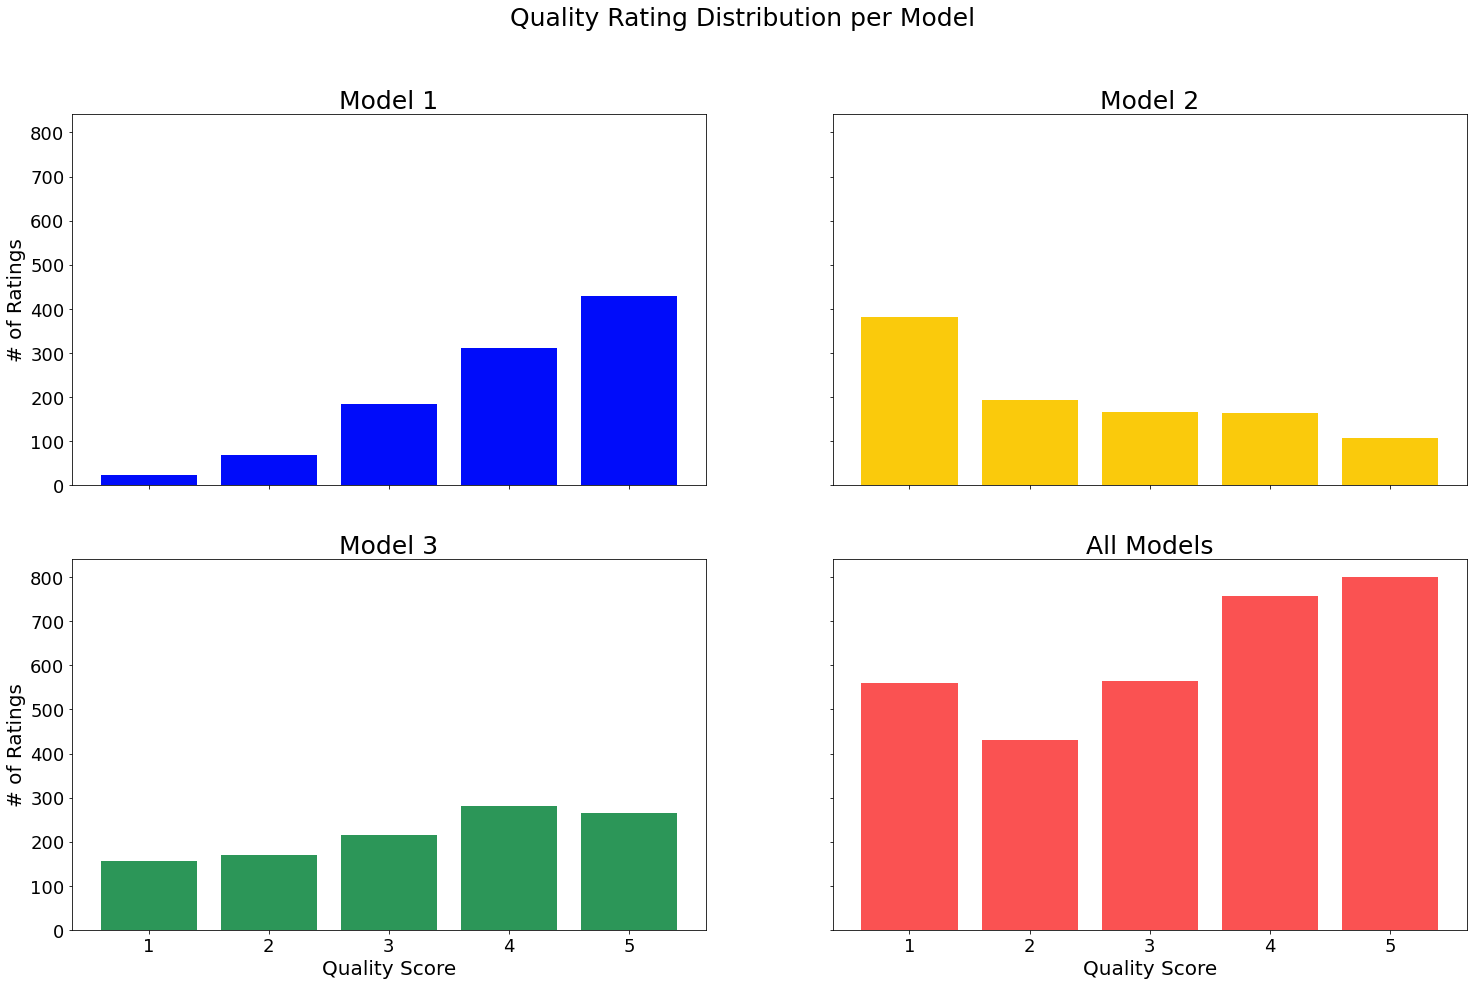

In [101]:
fig, axs = plt.subplots(2,2, figsize=(25,15), sharey=True,sharex=True)
title = 'Quality Rating Distribution per Model '
fig.suptitle(title, fontsize=25)
axs[0,0].tick_params(labelsize=18)
axs[0,0].bar(data_ds[data_ds['Model'] == 'M1']['quality'].value_counts().sort_index().index,data_ds[data_ds['Model'] == 'M1']['quality'].value_counts().sort_index().values, color=colors_dark[0])
axs[0,0].set_ylabel('# of Ratings', fontsize=20)
axs[0,0].set_title('Model 1', fontsize=25)

axs[0,1].bar(data_ds[data_ds['Model'] == 'M2']['quality'].value_counts().sort_index().index,data_ds[data_ds['Model'] == 'M2']['quality'].value_counts().sort_index().values, color=colors_dark[2])
axs[0,1].set_title('Model 2', fontsize=25)

axs[1,0].tick_params(labelsize=18)
axs[1,0].bar(data_ds[data_ds['Model'] == 'M3']['quality'].value_counts().sort_index().index,data_ds[data_ds['Model'] == 'M3']['quality'].value_counts().sort_index().values, color=colors_dark[3])
axs[1,0].set_ylabel('# of Ratings', fontsize=20)
axs[1,0].set_xlabel('Quality Score', fontsize=20)
axs[1,0].set_title('Model 3', fontsize=25)

axs[1,1].tick_params(labelsize=18)
axs[1,1].bar(data_ds['quality'].value_counts().sort_index().index,data_ds['quality'].value_counts().sort_index().values, color=colors_light[1])
axs[1,1].set_xlabel('Quality Score', fontsize=20)
axs[1,1].set_title('All Models', fontsize=25)

plt.show()